In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
fp = '../../data/snowschool/wx_data/winter_20_21.csv'

In [32]:
df = pd.read_csv(fp, skiprows=6)
df = df[2:]
df.Date_Time= pd.to_datetime(df.Date_Time)
for col in df.columns:
    try:
        df[col] = df[col].astype('f8')
    except:
        pass
df.loc[df['precip_accum_set_1']>800, 'precip_accum_set_1'] = df.loc[df['precip_accum_set_1']>800, 'precip_accum_set_1']/10 #remove some crazy temp spikes that are almost certaintly not real
df.loc[df['snow_depth_set_1']>2000, 'snow_depth_set_1'] = df.loc[df['snow_depth_set_1']>2000, 'snow_depth_set_1']/10 #remove some crazy temp spikes that are almost certaintly not real
df.loc[df['snow_depth_set_1']==1869.948, 'snow_depth_set_1'] = np.nan
df.loc[abs(df['snow_depth_set_1'] - df['snow_depth_set_1'].shift(18))>400, 'snow_depth_set_1'] = np.nan
df.loc[:,'snow_depth_set_1'] = df.loc[:,'snow_depth_set_1'].interpolate()
df.loc[df['air_temp_set_1'] < -20,'air_temp_set_1'] = np.nan

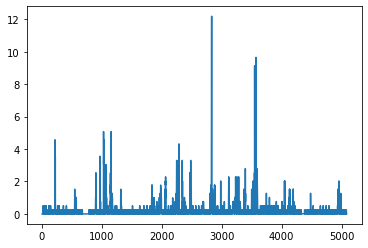

In [33]:
ppt_diff = df.precip_accum_set_1 - df.precip_accum_set_1.shift(1)
ppt_diff = ppt_diff[ppt_diff>=0]
ppt_diff = ppt_diff.interpolate()
plt.plot(ppt_diff)

In [34]:
new = pd.DataFrame()
new['timestamp'] = df.Date_Time
new['ta'] = df.air_temp_set_1.interpolate()+273.15
new['rh'] = df.relative_humidity_set_1.interpolate()/100
new['tsg'] = df.soil_temp_set_4.interpolate()+273.15
new['tss'] = df.surface_temp_set_1.interpolate()+273.15
new['hs'] = df.snow_depth_set_1.interpolate()/1000
new['vw'] = df.wind_speed_set_1.interpolate()
new['dw'] = df.wind_direction_set_1.interpolate()
new['oswr'] = df.outgoing_radiation_sw_set_1.interpolate()
new['iswr'] = df.solar_radiation_set_1.interpolate()
new['ilwr'] = df.incoming_radiation_lw_set_1.interpolate()
new['psum'] = ppt_diff[ppt_diff>-1].interpolate()
new.timestamp = new.timestamp.dt.strftime('%Y-%m-%dT%H:%M:%S')

In [35]:
new.to_csv('../../modeling/input/py-20-21.smet', index= False, header = False)

In [36]:
with open('../../modeling/input/py-20-21.smet', 'w') as f:
    f.write("""SMET 1.1 ASCII
[HEADER]
station_id       = WWA01
station_name     = Snow School 1
latitude         = 43.769320
longitude        = -116.110820
altitude         = 1902.0
easting          = 571564.970322
northing         = 4846636.397552
epsg             = 32611
nodata           = -999
tz               = -7
source           = WWA01 MesoWest
fields           = timestamp TA RH TSG TSS HS VW DW OSWR ISWR ILWR PSUM
plot_unit        = time K - K K m m/s - W/m2 W/m2 W/m2 mm 
[DATA]\n""")
    f.write(new.to_string(header = False, index = False, na_rep='-999',float_format=lambda x: '%.1f' % x))
    #f.write(re.sub(r'\s+', '   ', new.to_string(header = False, index = False, na_rep='-999', float_format=lambda x: '%.5f' % x)).replace('2020-','\n2020-').replace('2021-','\n2021-'))

In [37]:
proc = new.copy()
proc.iloc[0,:] = pd.Series(['-', 'K', '-', 'K', 'K', 'm', 'm/s', '-', 'W/m2', 'W/m2', 'W/m2', 'm']) 

In [38]:
proc.loc[proc.psum.isnull(), 'psum'] = 0
proc

,timestamp,ta,rh,tsg,tss,hs,vw,dw,oswr,iswr,ilwr,psum
2,-,K,-,K,K,m,m/s,-,W/m2,W/m2,W/m2,m
3,2020-10-02T01:00:00,292.67,0.1929,289.15,286.96,0.1651,0.91,351.2,14.15,57.22,237.8,0.0
4,2020-10-02T02:00:00,291.86,0.1793,286.89,283.83,0.164084,1.77,47.03,5.58,3.19,234.4,0
5,2020-10-02T03:00:00,292.24,0.1678,285.27,282.93,0.164084,1.54,54.17,4.36,0.0,238.1,0
6,2020-10-02T04:00:00,292.45,0.143,284.3,282.23,0.166878,0.9,65.73,5.1,0.0,239.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5076,2021-04-30T19:00:00,290.93,0.3109,288.76,279.02,0.37592,1.07,294.7,219.5,965.0,269.4,0.254
5077,2021-04-30T20:00:00,291.7,0.331,290.89,280.27,0.355092,1.57,341.2,246.7,1005.0,274.7,0.254
5078,2021-04-30T21:00:00,292.75,0.263,292.02,280.96,0.327914,1.64,348.4,243.2,940.0,273.5,0.0
5079,2021-04-30T22:00:00,291.5,0.3289,292.5,280.47,0.33401,1.54,312.7,179.1,674.5,292.2,0.0


In [29]:
proc.to_csv('../../modeling/wx_py_processed/winter_20_20_clean.csv', date_format='%Y-%m-%dT%H:%M:%S', index = False, na_rep='-999')

In [ ]:
# import re
# re.sub('\s+', '   ', new.fillna(-999).to_string(header = False, index = False, float_format=lambda x: '%.2f' % x)).replace('2020','\n2020')